Если делать локально, то не нужно выполнять слудеющую ячейку.

Также убрать из всех путей "/midIR"

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов
from numpy.fft import fft, rfft, irfft
import matplotlib as mpl
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Image,display

from reparse import reparse
import fourier
import data_from_input
import scipy
from source import source

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [3]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508
RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10
ElectronsPerCell = 2.35165e+16/18

rep = reparse()

# Theory


In [4]:
n_0, t_long, x_long, dxdt_long, az_i_long, az_r_long = rep.analytical_linear("./data/theory/linear/long")
n_0, t, x_steep, dxdt_steep, _, _ = rep.analytical_linear("./data/theory/linear/steep")

['./2.00/linear_long_n0_2.00.bin', './2.25/linear_long_n0_2.25.bin', './2.50/linear_long_n0_2.50.bin', './2.75/linear_long_n0_2.75.bin', './3.00/linear_long_n0_3.00.bin', './3.25/linear_long_n0_3.25.bin', './3.50/linear_long_n0_3.50.bin', './3.75/linear_long_n0_3.75.bin', './4.00/linear_long_n0_4.00.bin', './4.25/linear_long_n0_4.25.bin', './4.50/linear_long_n0_4.50.bin', './4.75/linear_long_n0_4.75.bin']
['./2.00/linear_steep_n0_2.00.bin', './2.25/linear_steep_n0_2.25.bin', './2.50/linear_steep_n0_2.50.bin', './2.75/linear_steep_n0_2.75.bin', './3.00/linear_steep_n0_3.00.bin', './3.25/linear_steep_n0_3.25.bin', './3.50/linear_steep_n0_3.50.bin', './3.75/linear_steep_n0_3.75.bin', './4.00/linear_steep_n0_4.00.bin', './4.25/linear_steep_n0_4.25.bin', './4.50/linear_steep_n0_4.50.bin', './4.75/linear_steep_n0_4.75.bin']


In [5]:
n_0

['2.00',
 '2.25',
 '2.50',
 '2.75',
 '3.00',
 '3.25',
 '3.50',
 '3.75',
 '4.00',
 '4.25',
 '4.50',
 '4.75']

## Result

In [6]:
def theory_graph(n0, max_x):
    f = plt.figure(figsize = (15,10))
    #plt.figure(figsize = (5,5))
    plt.plot(x_long[n0]*LightVelocity/Omega*1.e+4, dxdt_long[n0], linewidth = 3.0, label = "Long", linestyle = (0,(1,1)))
    plt.xlabel(r"$x_s, \mu m$")
    plt.ylabel(r"$V_x, c$")
    plt.yticks(np.arange(-1.0,1.1,0.1))
    plt.title("Long Phase portrait." + r" $n_0$ = {}".format(n_0[n0]))
    #plt.grid()
    #plt.show()
    
    #plt.figure(figsize = (5,5))
    plt.plot(x_steep[n0]*LightVelocity/Omega*1.e+4, dxdt_steep[n0], linewidth = 3.0, label = "Steep")
    plt.xlabel(r"$x_s, \mu m$")
    plt.ylabel(r"$V_x, c$")
    plt.yticks(np.arange(-1.0,1.1,0.1))
    plt.title("Phase portrait." + r" $n_0$ = {}".format(n_0[n0]))
    plt.grid()
    plt.legend(loc = "best")
    #plt.show()

In [7]:
interactive_plot = interactive(theory_graph,
                            n0 = widgets.IntSlider(min=0,max=11,step=1,value= 0),
                            max_x = widgets.FloatText(value= 3))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='n0', max=11), FloatText(value=3.0, description='max_x'),…

# Compare

In [8]:
name_linear = "./data/specs/linear"

Ниже на картинках:

нижние индексы i,r различают падающие/отраженные поля;

верхние индесы t,s показывают способ получения результата (теория, моделирование);

ключевые слова steep, long различают форму падающего импульса (с резким и плавным передними фронтами соответственно), где не указано, подразумеваются импульсы с резким передним фронтом.

## Code

In [9]:
(n_0_linear, lambda_i_ad_linear, fft_i_ad_linear,
 fft_r_ad_linear, lambda_i_sim_linear, fft_r_sim_linear) = rep.linear(name_linear)


range1 = (3, 50)
path = r"./data/source/l_long_4.0_2021-06-22_10-01-15" #  n_* *=1.1, 3, 4, 10
delta_t, delta_x, a_rel, n, focal_spot_fwhm = data_from_input.parameters_from_input(path)
bz, x_array = data_from_input.reparse(path, "bz2dxy", a_rel, delta_x)
by = data_from_input.reparse(path, "by2dxy", a_rel, 0)
ey = data_from_input.reparse(path, "ey2dxy", a_rel, 0)
ez = data_from_input.reparse(path, "ez2dxy", a_rel, 0)
n_e = data_from_input.reparse(path, "electron2dxy", n, 0)

mask_2d = np.where((np.sqrt(bz**2 + by**2) > 5e-3), 1, 0)
mask_ne = np.where(n_e > 9e-1, 0.99, 0.01)

1
['./LinearPolarization_n0_01.bin', './LinearPolarization_n0_02.bin', './LinearPolarization_n0_03.bin', './LinearPolarization_n0_04.bin', './LinearPolarization_n0_05.bin', './LinearPolarization_n0_06.bin', './LinearPolarization_n0_07.bin', './LinearPolarization_n0_08.bin', './LinearPolarization_n0_09.bin', './LinearPolarization_n0_10.bin', './LinearPolarization_n0_11.bin', './LinearPolarization_n0_12.bin', './LinearPolarization_n0_13.bin', './LinearPolarization_n0_14.bin', './LinearPolarization_n0_15.bin', './LinearPolarization_n0_16.bin', './LinearPolarization_n0_17.bin', './LinearPolarization_n0_18.bin', './LinearPolarization_n0_19.bin', './LinearPolarization_n0_20.bin']


In [10]:
by_r = (ez+by)/2
by_i = (-ez+by)/2

bz_r = (-ey+bz)/2
bz_i = (ey+bz)/2

In [29]:
np.argmax(az_r_long[-4])

0

(0.0, 150.0, -40.0, 40.0)

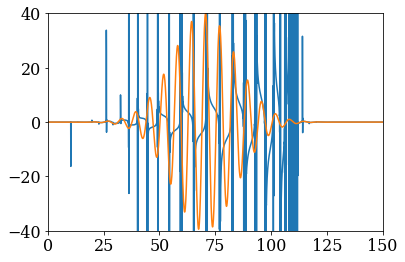

In [25]:
plt.plot(t_long[-4], az_r_long[-4])
plt.plot(t_long[-4], az_i_long[-4])
plt.axis([0,150, -40, 40])

In [31]:
np.fft.rfft(az_r_long[-4][1:])

array([-2854988.60524109      +0.j        ,
       -2604503.04937455+1191036.39921666j,
       -1894034.1476527 +2183097.86347957j, ...,
       -4461308.15496666-3083094.71679204j,
       -5179949.7263406 -1614546.44755717j,
       -5426608.90101423      +0.j        ])

In [32]:
filtered_bz_linear = source(bz_i, bz_r, range1)
#filtered_by_linear = source(by_i, by_r, range1)
t_linear = np.linspace(0,400, filtered_bz_linear.shape[0])

n0 = 4.0

fourier_i_ad, fourier_r_ad, base_ad, omega_ad, flambda_ad, fourierl_i_ad, fourierl_r_ad = fourier.fourier_of_field(az_i_long[-4][1:], az_r_long[-4][1:], 0.8, True)
fourier_i_sim, fourier_r_sim, base_sim, omega_sim, flambda_sim, fourierl_i_sim, fourierl_r_sim = fourier.fourier_of_field(bz_i[:,3600], bz_r[:,2500], 0.8, True)
spec_filtered_linear = fourier.spec_filter(fourierl_r_sim[:], flambda_sim[:], range1, "tophat")

In [23]:
"""az_r_long = np.array(az_r_long)
az_r_long_new = az_r_long[-4].copy()
mask = np.where(az_r_long[-4] > 40)
az_r_long_new[mask] = 40
mask = np.where(az_r_long[-4] < -40)
az_r_long_new[mask] = -40"""

'az_r_long = np.array(az_r_long)\naz_r_long_new = az_r_long[-4].copy()\nmask = np.where(az_r_long[-4] > 40)\naz_r_long_new[mask] = 40\nmask = np.where(az_r_long[-4] < -40)\naz_r_long_new[mask] = -40'

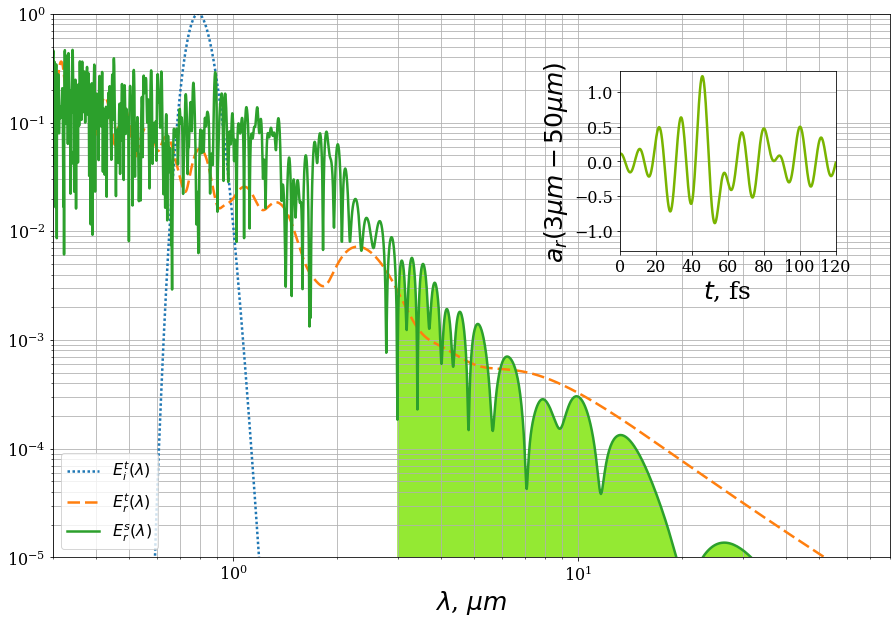

In [38]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.axes()  # standard axes
plt.xlabel(r"$\lambda$, $\mu m$", fontsize=25)
plt.fill_between(flambda_sim[:] ,abs(spec_filtered_linear), 1e-8, color=(121/255, 228/255, 0, 0.8))
ax2 = plt.axes([0.65, 0.55, 0.20, 0.25])

ax1.loglog(flambda_ad[:] , abs(fourierl_i_ad[:]), linewidth = 2.5, label = r'$E^t_{i}(\lambda)$', linestyle = (0,(1,1)))
ax1.loglog(flambda_ad[:] , abs(fourierl_r_ad[:])/5e+3, linewidth = 2.5, label = r'$E^t_{r}(\lambda)$', linestyle = (0,(5,2)))
ax1.loglog(flambda_sim[:] , abs(fourierl_r_sim[:]), linewidth = 2.5, label = r'$E^s_{r}(\lambda)$')
ax1.legend(loc = "lower left")
ax1.axis((3e-1,8e+1,1e-5,1))
ax2.plot(t_linear - 50, filtered_bz_linear[:,2666], linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
ax2.set_xticks(np.arange(0,150,20))
ax2.set_yticks(np.arange(-4,5,0.5))
ax2.axis([-0, 120,-1.3,1.3])
plt.xlabel(r"$t$, fs", fontsize=25)
plt.ylabel(r"$a_r({}\mu m-{}\mu m)$".format(range1[0], range1[1]), fontsize=25)
ax1.grid(True, which="both")
ax2.grid(True, which="both")
plt.show()

# Energy

In [45]:
'''folder_name_linear_steep = "./midIR/data/energy/linear_steep"
folder_name_linear_long = "./midIR/data/energy/linear_long"'''
folder_name_linear_steep = "./data/energy/linear_steep"
folder_name_linear_long = "./data/energy/linear_new"
folder_name_linear_new = "./data/energy/linear_new"

## Code

In [46]:
n_0_linear_long, lambda_s_linear_long, energy_linear_long, num_n_linear_long = rep.energy(folder_name_linear_long, "n0*.bin")

for i in range(len(n_0_linear_long)):
    lambda_s_linear_long[i] = [x for _,x in sorted(zip(n_0_linear_long[i],lambda_s_linear_long[i]))]
    energy_linear_long[i] = [x for _,x in sorted(zip(n_0_linear_long[i],energy_linear_long[i]))]
    n_0_linear_long[i].sort()

['./n0_22.0.bin', './n0_5.0.bin', './n0_4.0.bin', './n0_28.0.bin', './n0_18.0.bin', './n0_32.0.bin', './n0_24.0.bin', './n0_10.0.bin', './n0_20.0.bin', './n0_14.0.bin', './n0_26.0.bin', './n0_13.0.bin', './n0_29.0.bin', './n0_21.0.bin', './n0_34.0.bin', './n0_31.0.bin', './n0_6.0.bin', './n0_1.0.bin', './n0_35.0.bin', './n0_3.0.bin', './n0_11.0.bin', './n0_17.0.bin', './n0_25.0.bin', './n0_8.0.bin', './n0_30.0.bin', './n0_33.0.bin', './n0_15.0.bin', './n0_23.0.bin', './n0_9.0.bin', './n0_19.0.bin', './n0_27.0.bin', './n0_16.0.bin', './n0_7.0.bin', './n0_12.0.bin', './n0_2.0.bin']


## Code

In [47]:
from matplotlib.colors import LogNorm

In [48]:
def built_graph_linear_long(dl, range_l, range_n0, ulimit_e, llimit_e, dl_graph):
    max_l = range_l[1]
    min_l = range_l[0]
    num_ll = int((max_l-min_l)/dl)
    range1 = np.zeros((num_ll,num_n_linear_long))
    for i in np.arange(0, num_n_linear_long):
        for j in np.arange(0,num_ll):
            mask = np.where((lambda_s_linear_long.T[i] > min_l+j*dl) & (lambda_s_linear_long.T[i] < min_l+(j+1)*dl))[0]
            for i1 in mask:
                range1[j][i] += energy_linear_long[i1,i]        
    fig = plt.figure(figsize=(20,10))
    c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_long[0,num_n_linear_long-1]+0.5,0.5), aspect = "auto",  interpolation='bicubic',norm=LogNorm(vmin=llimit_e, vmax=ulimit_e))
    #c_ax = plt.imshow(range1.T, extent = (min_l,min_l + dl*num_ll,n_0_linear_long[0,num_n_linear_long-4-1]+0.5,0.5), aspect = "auto", vmax = limit_e, vmin = 0,  interpolation='bicubic',norm=LogNorm(vmin=0.01, vmax=1))
    plt.xticks(np.arange(min_l,max_l,dl_graph))
    plt.xlabel(r"$\lambda ,$ $\mu m$")
    plt.yticks(np.arange(1,n_0_linear_long[0,num_n_linear_long-1],2))
    plt.ylabel(r"$n_0$")
    cbar = plt.colorbar()
    cbar.set_label("Energy, arb.u.")
    plt.axis([min_l,max_l,range_n0[1],range_n0[0]])
    plt.title(r"$\updownarrow$ long")
    plt.grid()
    plt.show()

## Result ($\updownarrow$ long)

In [49]:
interactive_plot = interactive(built_graph_linear_long,
                            dl = widgets.FloatText(value= 0.04),
                            range_l = widgets.FloatRangeSlider(min=0,max=20,step=0.1,value= [0.5, 10.0]),
                            range_n0 = widgets.FloatRangeSlider(min=1,max=35,step=1,value= [1, 35]),
                            ulimit_e = widgets.FloatText(value= 3.0),
                            llimit_e = widgets.FloatText(value= 1e-5),
                            dl_graph = widgets.FloatText(value= 0.5))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatText(value=0.04, description='dl'), FloatRangeSlider(value=(0.5, 10.0), description…

# 2D

![Cat](./2D_n0_4.0.png)

# 2D(диаграммы направленности)

## Code

In [41]:
def read_file(dim1, dim2, name_of_file):
    with open(name_of_file, "r") as file:
        line = file.read()
        data = line.split("    ")
        omega = np.zeros(dim1)
        lambda_w = np.zeros(dim1)
        rcs = np.zeros((dim1,dim2))
        for i in range(dim1):
            omega[i] = float(data[0+i*(dim2+2)])
            #print(i)
            lambda_w[i] = float(data[1+i*(dim2+2)])
            rcs[i,:] = data[2+i*(dim2+2):(i+1)*(dim2+2)]
    return omega, lambda_w, rcs

In [40]:
omega_d_04, lambda_w_d_04, rcs_d_04 = read_file(446, 3001, r"./data/2D/defect_n4.0.dat")
omega_d_16, lambda_w_d_16, rcs_d_16 = read_file(446, 3001, r"./data/2D/defect_n16.0.dat")
omega_s_04, lambda_w_s_04, rcs_s_04 = read_file(446, 3001, r"./data/2D/linear_steep_n4.0.dat")
omega_s_16, lambda_w_s_16, rcs_s_16 = read_file(446, 3001, r"./data/2D/linear_steep_n16.0.dat")
phi = 2*np.pi/rcs_d_04.shape[1]*np.arange(rcs_d_04.shape[1])

In [7]:
rcs_d_04.shape

(446, 3001)

In [8]:
rcs_d_04[60,:-1].shape

(3000,)

In [27]:
phi[750]

1.5702729024940651

In [42]:
def graph(lambda_w, dlambda, num_lambda):
    neww_rcs = []
    lambda_new = dlambda*np.arange(num_lambda)
    for i in range(num_lambda):
        mask = np.where((lambda_w_d_04>i*dlambda) & (lambda_w_d_04<(i+1)*dlambda))
        neww_rcs.append(np.sum(rcs_d_04[mask], axis = 0))
    neww_rcs = np.array(neww_rcs)
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m - {:.02f}\mu m $".format(lambda_new[lambda_w],lambda_new[lambda_w+1]))
    plt.polar(phi[749:-750], neww_rcs[lambda_w,749:-750], label = r"$n_0 = 4.0$ defect", linewidth = 2.0)
    plt.polar(phi[749:-750], rcs_s_04[lambda_w,749:-750], label = r"$n_0 = 4.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

In [43]:
interactive_plot = interactive(graph,
                            lambda_w = widgets.IntSlider(min=0, max = 200,step=1,value= 2),
                            dlambda = widgets.FloatText(value= 0.5),
                            num_lambda=widgets.IntSlider(min=0, max = 200,step=1,value= 100))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=2, description='lambda_w', max=200), FloatText(value=0.5, description='d…

In [44]:
def graph(lambda_w):
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m$".format(lambda_w_d_04[lambda_w]))
    plt.polar(phi, rcs_d_04[lambda_w,:], label = r"$n_0 = 4.0$ defect", linewidth = 2.0)
    plt.polar(phi, rcs_s_04[lambda_w,:]*1000, label = r"$n_0 = 4.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

## Result

In [26]:
interactive_plot = interactive(graph,
                            lambda_w = widgets.IntSlider(min=0, max = rcs_d_04.shape[0]-1,step=1,value= 60),
                            )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=60, description='lambda_w', max=445), Output()), _dom_classes=('widget-i…

In [23]:
def graph(lambda_w):
    f = plt.figure(figsize = (12,12))
    f.suptitle(r"$\lambda = {:.02f}\mu m$".format(lambda_w_d_04[lambda_w]))
    plt.polar(phi, rcs_d_16[lambda_w,:], label = r"$n_0 = 16.0$ defect", linewidth = 2.0)
    plt.polar(phi, rcs_s_16[lambda_w,:]*1000, label = r"$n_0 = 16.0$ steep", linewidth = 2.0)
    plt.legend()
    #plt.grid()

In [24]:
interactive_plot = interactive(graph,
                            lambda_w = widgets.IntSlider(min=0, max = rcs_d_04.shape[0]-1,step=1,value= 6),
                            )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=6, description='lambda_w', max=445), Output()), _dom_classes=('widget-in…